In [1165]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotUniform

In [1166]:
train = pd.read_csv('C:/Users/whileduck/Desktop/캐글/train.csv')
test = pd.read_csv('C:/Users/whileduck/Desktop/캐글/test.csv')

In [1167]:
df = train.copy()

In [1168]:
print('데이터 프레임의 형태는 : \n', df.shape)

print('데이터의 독립 변수 명은 : \n', df.columns[:-1])

print('데이터의 타겟값의 종류는 \n', df['prognosis'].unique())

데이터 프레임의 형태는 : 
 (707, 66)
데이터의 독립 변수 명은 : 
 Index(['id', 'sudden_fever', 'headache', 'mouth_bleed', 'nose_bleed',
       'muscle_pain', 'joint_pain', 'vomiting', 'rash', 'diarrhea',
       'hypotension', 'pleural_effusion', 'ascites', 'gastro_bleeding',
       'swelling', 'nausea', 'chills', 'myalgia', 'digestion_trouble',
       'fatigue', 'skin_lesions', 'stomach_pain', 'orbital_pain', 'neck_pain',
       'weakness', 'back_pain', 'weight_loss', 'gum_bleed', 'jaundice', 'coma',
       'diziness', 'inflammation', 'red_eyes', 'loss_of_appetite',
       'urination_loss', 'slow_heart_rate', 'abdominal_pain',
       'light_sensitivity', 'yellow_skin', 'yellow_eyes', 'facial_distortion',
       'microcephaly', 'rigor', 'bitter_tongue', 'convulsion', 'anemia',
       'cocacola_urine', 'hypoglycemia', 'prostraction', 'hyperpyrexia',
       'stiff_neck', 'irritability', 'confusion', 'tremor', 'paralysis',
       'lymph_swells', 'breathing_restriction', 'toe_inflammation',
       'finger_infla

# 데이터 설명

##### Goal : Ventor Borne Disaeae 의 symptom을 보고 질병 명을 예측 
##### object : Vector Bornn Disease 란 혈액을 통해 모기, 진드기, 벼룩과 같은 피를 빨아먹는 곤충이 매개체가 되어 전염되는 질병
 
##### 평가 지표 : MAP@K metrics (MAP@K = (1 / |Q|) * Σ(q=1에서 |Q|) Σ(k=1에서 K) (P(k) * rel(k)) / min(|R| , 케이))

    *  각 실제 레이블에 대한 예측 값들(예측 확률)을 가장 실제값과 가까운 순으로 나열 
    *  1 개부터 K 개 까지의 Precision 계산 
    * 실제값이 Malaria고, 예측 값을 K 개 까지 나열한 결과가 Zika, Dengue, Plague 라면 
    * 1 일 때의 precision = 실제값 / 예측값이니 , 1일 때는 precision 이 1, 2일 때는 precision 이 0.5, 3일 때는 0.33 .. 
    * 이런식으로 각 i 번째 레이블에 대한 AP@K(average Precision) 계산
    * 이후 각 인덱스에 대한 AP 들의 평균인 AP@K 를 계산

    * 그러니 현 모델에선 소프트 맥스로 다중 분류된 예측 값들 중 가장 첫 번째로 실제 레이블을 맞췄을 경우의 AP@K , MAP@K 가 높을 것이다.






# 데이터 탐색

In [1169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     707 non-null    int64  
 1   sudden_fever           707 non-null    float64
 2   headache               707 non-null    float64
 3   mouth_bleed            707 non-null    float64
 4   nose_bleed             707 non-null    float64
 5   muscle_pain            707 non-null    float64
 6   joint_pain             707 non-null    float64
 7   vomiting               707 non-null    float64
 8   rash                   707 non-null    float64
 9   diarrhea               707 non-null    float64
 10  hypotension            707 non-null    float64
 11  pleural_effusion       707 non-null    float64
 12  ascites                707 non-null    float64
 13  gastro_bleeding        707 non-null    float64
 14  swelling               707 non-null    float64
 15  nausea

* Target 값의 분포

(-0.5, 10.5)

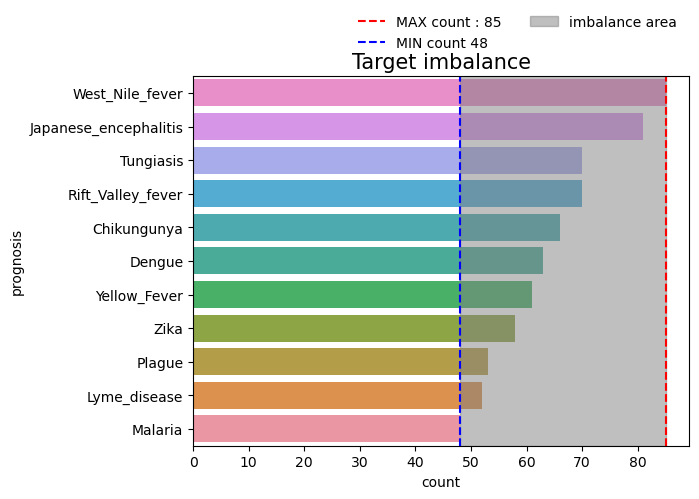

In [1170]:
prognosis_idx = df['prognosis'].value_counts().index.tolist()[::-1]
prognosis_val = df['prognosis'].value_counts().values.tolist()

min_count = min(prognosis_val)
max_count = max(prognosis_val)

sns.countplot(y = df['prognosis'], order = prognosis_idx)

plt.axvline(max_count,
            c = 'r', ls = '--',
            label = f'MAX count : {max_count}')
plt.axvline(min_count,
            c = 'b', ls = '--',
            label = f'MIN count {min_count}')

plt.fill_betweenx([-0.5, len(prognosis_idx)], x1=min_count, x2=max_count, color='grey', alpha=0.5,
                    label = 'imbalance area')

plt.title('Target imbalance', fontdict = {'size':15})
plt.legend(loc = 'upper right',
            bbox_to_anchor = (1,1.2),
            ncol = 2,
            frameon = False)

plt.ylim([-0.5,10.5])

* 종속 변수 별 클래스 불균형이 심하다.
* 이는 클래스의 빈도가 적은 경우의 가중치가 적절하게 업데이트 되지 않을 수 있으니 SMOTE 를 이용해서 오버샘플링 해주자

### SMOTE

    SMOTE는 Synthetic Minority Over-sampling Technique의 약자입니다. 기계 학습에서 클래스 불균형을 해결하는 데 사용되는 인기 있는 기술입니다. 클래스 불균형이 있는 데이터 세트에서 소수 클래스는 다수 클래스에 비해 샘플이 적기 때문에 소수 클래스에서 기계 학습 알고리즘의 성능이 저하될 수 있습니다.


    SMOTE는 소수 클래스 샘플 사이를 보간하여 소수 클래스의 합성 샘플을 생성하는 오버샘플링 기술입니다.
    이는 임의의 소수 클래스 샘플을 선택하고 k개의 가장 가까운 이웃을 찾아 수행됩니다.
    그런 다음 이웃을 무작위로 선택하고 선택한 소수 샘플과 선택한 이웃 사이를 보간하여 합성 샘플을 생성합니다.
    이 프로세스는 원하는 수준의 오버샘플링이 달성될 때까지 계속됩니다.


    결과 합성 샘플은 클래스 분포의 균형을 맞추고 기계 학습 알고리즘의 성능을 향상시키는 데 도움이 됩니다.
    SMOTE는 사기 감지, 의료 진단 및 텍스트 분류와 같이 클래스 불균형이 일반적인 애플리케이션에 널리 사용됩니다.



* 문자형 변수 라벨링

In [1171]:
reverse_labels= {}
uniques = df['prognosis'].unique()

for i,uni in enumerate(uniques):
    
    reverse_labels[i] = uni 
    
    
print(reverse_labels)

{0: 'Lyme_disease', 1: 'Tungiasis', 2: 'Zika', 3: 'Rift_Valley_fever', 4: 'West_Nile_fever', 5: 'Malaria', 6: 'Chikungunya', 7: 'Plague', 8: 'Dengue', 9: 'Yellow_Fever', 10: 'Japanese_encephalitis'}


In [1172]:
labels= {}
uniques = df['prognosis'].unique()

for i,uni in enumerate(uniques):
    
    labels[uni] = i 
    
df['prognosis'] = df['prognosis'].map(labels)

In [1173]:
X = df.drop(['id','prognosis'],axis = 1)
Y = df['prognosis']

* 오버샘플링은 잘 작동할까?

In [1174]:
x_train_full, x_test,y_train_full, y_test = train_test_split(X,Y,stratify = Y, random_state = 42)

In [1175]:
x_train,x_valid,y_train,y_valid = train_test_split(x_train_full,y_train_full,
                                                    random_state = 42)


In [1176]:
sm = SMOTE(k_neighbors= 3, random_state = 77)

x_train_resample, y_train_resample = sm.fit_resample(x_train,y_train)

In [1177]:
print('Original feature shape :', x_train.shape)
print('Original target shape :', y_train.shape)

print('**'* 20)

print('After SMOTE feature shape :', x_train_resample.shape)
print('After SMOTE target shape :', y_train_resample.shape)

Original feature shape : (397, 64)
Original target shape : (397,)
****************************************
After SMOTE feature shape : (495, 64)
After SMOTE target shape : (495,)


In [1178]:
num_classes = Y.nunique()

y_train = pd.DataFrame(tf.one_hot(y_train, num_classes))
y_train_resample = pd.DataFrame(tf.one_hot(y_train_resample, num_classes))

y_valid = pd.DataFrame(tf.one_hot(y_valid, num_classes))

In [1179]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                patience = 30)

In [1180]:
def create_model(x_shape = (64,),layer = 5,
                    node = 32 ,activation_ = 'relu', y_shape = 11,
                    l2_input_ = 0,
                    input_optimizer = 'adam',
                    loss_fn = CategoricalCrossentropy()):
    
    model = Sequential()
    
    model.add(Dense(node, input_shape=x_shape, kernel_initializer=GlorotUniform()))
    for l in range(layer):
        model.add(Dense(node, activation = activation_,
                        kernel_regularizer = regularizers.l2(l2_input_)))
        
        
    model.add(Dense(units = y_shape,
                                activation = 'softmax'))
    
    model.compile(optimizer = input_optimizer,
                    loss = loss_fn,
                    metrics = ['accuracy'])
    
    return model

In [1181]:
before_model = create_model(node = 32,layer = 3, l2_input_ = 0.01)
after_model = create_model(node = 32,layer = 3, l2_input_ = 0.01)

In [1182]:
before_history = before_model.fit(x_train,y_train,
            validation_data = (x_valid,y_valid),
            epochs = 1000,
            callbacks = early_stopping,
            verbose = 0)

In [1183]:
after_history = after_model.fit(x_train_resample,y_train_resample,
            validation_data = (x_valid,y_valid),
            epochs = 1000,
            callbacks = early_stopping,
            verbose = 0)

In [1184]:
before = pd.DataFrame(before_history.history)
after = pd.DataFrame(after_history.history)

results = [before,after]

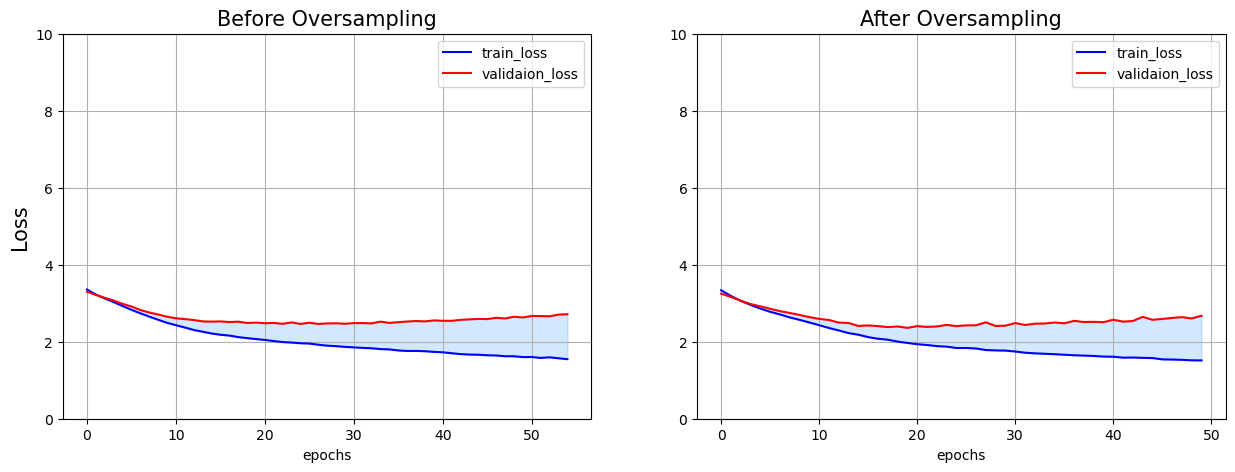

In [1185]:
fig,ax = plt.subplots(nrows = 1, ncols = 2,
                        figsize = (15,5))

ax = ax.flatten()

names = ['Before Oversampling', 'After Oversampling']

for i,var in enumerate(results):
    
    ax[i].grid()
    
    
    ax[i].plot(var['loss'],
                c = 'blue',
                label = 'train_loss')
    
    ax[i].plot(var['val_loss'],
                c = 'red',
                label = 'validaion_loss')
    
    ax[i].fill_between(range(len(var['loss'])), var['loss'], var['val_loss'], 
                    where=(var['loss'] <= var['val_loss']), 
                    interpolate=True, color='dodgerblue', alpha=0.2)

    
    ax[i].set_ylim([0,10])
    
    ax[i].set_title(names[i], fontsize = 15)
    
    ax[i].set_xlabel('epochs')
    ax[0].set_ylabel('Loss',fontsize = 15)
    
    ax[i].legend()

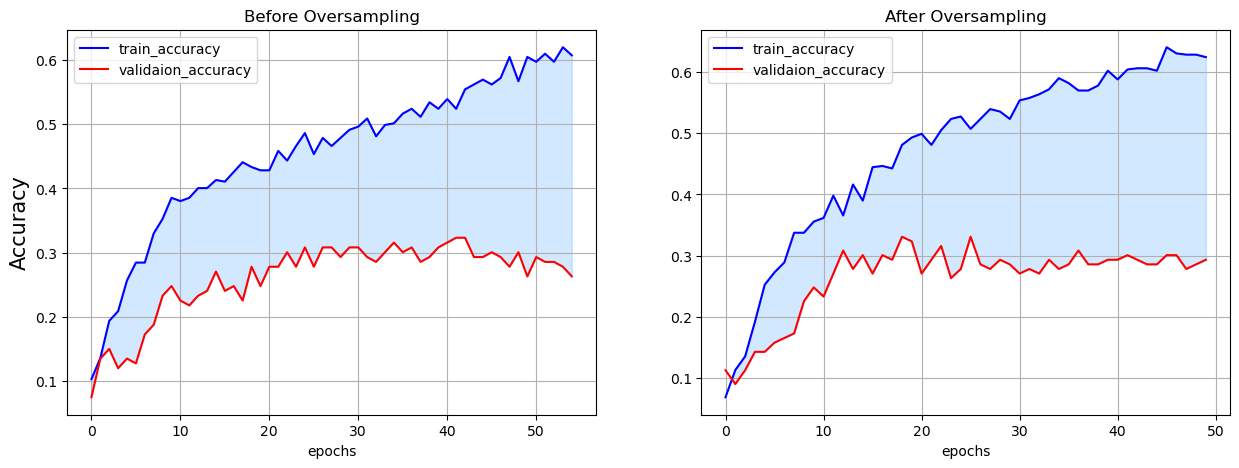

In [1186]:
fig,ax = plt.subplots(nrows = 1, ncols = 2,
                        figsize = (15,5))

ax = ax.flatten()

for i,var in enumerate(results):
    
    ax[i].grid()
    
    
    ax[i].plot(var['accuracy'],
                c = 'blue',
                label = 'train_accuracy')
    
    ax[i].plot(var['val_accuracy'],
                c = 'red',
                label = 'validaion_accuracy')
    
    ax[i].fill_between(range(len(var['accuracy'])), var['accuracy'], var['val_accuracy'], 
                        where=(var['accuracy'] >= var['val_accuracy']), 
                        interpolate=True, color='dodgerblue', alpha=0.2)
    
    
    ax[i].set_xlabel('epochs')
    ax[0].set_ylabel('Accuracy',fontsize = 15)

    ax[i].set_title(names[i])
    
    ax[i].legend()
    

In [1187]:
before_prob = before_model.predict(x_test)

after_prob = after_model.predict(x_test)

6/6 [==============================] - 0s 770us/step


In [1188]:
def mpk(y_test, predicted):
    """
    Calculates the mean precision at k for a given set of predictions.
    Args:
        y_test (pd.Series): Actual values for the test set
        predicted (np.ndarray): Predicted values for the test set
    Returns:
        mpk_score (float): Mean precision at k score for the test set
    """
    k = 3
    mpk_score = 0
    for i, y in enumerate(y_test):
        top_k_preds = predicted[i].argsort()[-k:][::-1]
        mpk_score += np.mean([1 if y in top_k_preds[:j+1] else 0 for j in range(k)])
    mpk_score /= len(y_test)
    return mpk_score

In [1189]:
print('Before Oversampling : ',mpk(y_test,before_prob))

Before Oversampling :  0.43691148775894517


In [1190]:
print('After Oversampling :',mpk(y_test,after_prob))

After Oversampling : 0.4143126177024482


In [1191]:
before_top3 = []

for prob in before_prob:
    before_top3.append(
        prob.argsort()[-3:][::-1 ]
    )
    
after_top3 = []

for prob in after_prob:
    after_top3.append(
        prob.argsort()[-3:][::-1]
    )

In [1192]:
print('Before oversampling result')
display(before_top3[:3])
print('**'*20)
print('After oversampling result')
display(after_top3[:3])

Before oversampling result


[array([ 0,  4, 10], dtype=int64),
 array([10,  4,  9], dtype=int64),
 array([ 3,  8, 10], dtype=int64)]

****************************************
After oversampling result


[array([8, 3, 0], dtype=int64),
 array([9, 7, 4], dtype=int64),
 array([ 1,  3, 10], dtype=int64)]

In [1193]:
def reverse(data):
    
    cols = data.columns
    
    for col in cols:
        
        data[col] = data[col].map(reverse_labels)
        
        # reverse_label : {0: 'Lyme_disease', 1: 'Tungiasis', 2: 'Zika', 3: 'Rift_Valley_fever' ... } ..
        
    data['predicteds'] = data[0] + ' ' + data[1] + ' ' + data[2]
    
    data = data.drop([0,1,2],axis = 1)
            
    return data

In [1194]:
before_top3 = pd.DataFrame(before_top3)
after_top3 = pd.DataFrame(after_top3)

In [1195]:
before_top3 = reverse(before_top3)
after_top3 = reverse(after_top3)

In [1196]:
before_top3['Real'] = y_test.map(reverse_labels).reset_index(drop = True)
after_top3['Real'] = y_test.map(reverse_labels).reset_index(drop = True)


print('Before Pversampling Predict')
display(before_top3.head(10))
print('\n\n')
print('After Oversamplig predict')
display(after_top3.head(10))

Before Pversampling Predict


,predicteds,Real
0,Lyme_disease West_Nile_fever Japanese_encephal...,Tungiasis
1,Japanese_encephalitis West_Nile_fever Yellow_F...,Plague
2,Rift_Valley_fever Dengue Japanese_encephalitis,Rift_Valley_fever
3,Japanese_encephalitis Chikungunya West_Nile_fever,Japanese_encephalitis
4,Rift_Valley_fever Dengue Japanese_encephalitis,West_Nile_fever
5,West_Nile_fever Japanese_encephalitis Yellow_F...,West_Nile_fever
6,Chikungunya West_Nile_fever Dengue,Yellow_Fever
7,Zika Yellow_Fever West_Nile_fever,Yellow_Fever
8,Yellow_Fever Plague West_Nile_fever,Malaria
9,Lyme_disease West_Nile_fever Malaria,Malaria





After Oversamplig predict


,predicteds,Real
0,Dengue Rift_Valley_fever Lyme_disease,Tungiasis
1,Yellow_Fever Plague West_Nile_fever,Plague
2,Tungiasis Rift_Valley_fever Japanese_encephalitis,Rift_Valley_fever
3,Yellow_Fever Plague Malaria,Japanese_encephalitis
4,Rift_Valley_fever Tungiasis Dengue,West_Nile_fever
5,West_Nile_fever Yellow_Fever Plague,West_Nile_fever
6,Chikungunya Japanese_encephalitis Rift_Valley_...,Yellow_Fever
7,Zika Yellow_Fever Plague,Yellow_Fever
8,Japanese_encephalitis Yellow_Fever Tungiasis,Malaria
9,Japanese_encephalitis West_Nile_fever Yellow_F...,Malaria


# 제출

In [1197]:
probs = after_model.predict(test.drop('id',axis = 1))

10/10 [==============================] - 0s 750us/step


In [1198]:
test

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,708,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,709,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,710,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,711,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1005,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299,1006,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,1007,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
301,1008,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1199]:
probs  = result_model.predict(test.drop('id',axis = 1))

result = []

for prob in probs:
    
    result.append(prob.argsort()[-3:][::-1])

10/10 [==============================] - 0s 632us/step


In [1200]:
sub = pd.read_csv('C:/Users/whileduck/Desktop/캐글/sample_submission.csv')
sub

,id,prognosis
0,707,Dengue Zika Japanese_encephalitis
1,708,Dengue Zika Japanese_encephalitis
2,709,Dengue Zika Japanese_encephalitis
3,710,Dengue Zika Japanese_encephalitis
4,711,Dengue Zika Japanese_encephalitis
...,...,...
298,1005,Dengue Zika Japanese_encephalitis
299,1006,Dengue Zika Japanese_encephalitis
300,1007,Dengue Zika Japanese_encephalitis
301,1008,Dengue Zika Japanese_encephalitis


In [1201]:
sub['prognosis'] = reverse(pd.DataFrame(result))

sub.to_csv('oversampling.csv',
            index = False)

In [1202]:
sub

,id,prognosis
0,707,Tungiasis Rift_Valley_fever Japanese_encephalitis
1,708,Dengue Malaria Chikungunya
2,709,West_Nile_fever Japanese_encephalitis Rift_Val...
3,710,Yellow_Fever Zika Japanese_encephalitis
4,711,Lyme_disease West_Nile_fever Malaria
...,...,...
298,1005,Yellow_Fever Japanese_encephalitis Zika
299,1006,Malaria Lyme_disease Plague
300,1007,Lyme_disease West_Nile_fever Malaria
301,1008,Japanese_encephalitis Rift_Valley_fever West_N...
